In [72]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm_notebook

from fastai.conv_learner import ConvLearner
from fastai.dataset import ImageClassifierData, get_cv_idxs
from fastai.transforms import tfms_from_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
%matplotlib inline

# Lesson 3 - Recreating the spreadsheet CNN in PyTorch

In [74]:
PATH = Path('./data/mnist')
PATH.mkdir(exist_ok=True)

## Dataset

In [6]:
!kaggle competitions download -c digit-recognizer --path={PATH}

In [7]:
df = pd.read_csv(PATH/'train.csv')

In [8]:
df.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Kaggle provides us the MNIST data all contained within the CSV file. Each row represents an image, with each column past the first is a pixel value.

We can load all pixels for a single image as follows:

In [76]:
img_pixels = df.loc[7, [c for c in df.columns if c.startswith('pixel')]]

In [77]:
img_pixels.shape

(784,)

In [78]:
img_arr = np.array([int(i) for i in img_pixels])

In [79]:
img_arr.shape

(784,)

We can reshape it into a square, then take a look at one of the images

In [80]:
img_arr = img_arr.reshape((28, 28))

In [81]:
img_arr.shape

(28, 28)

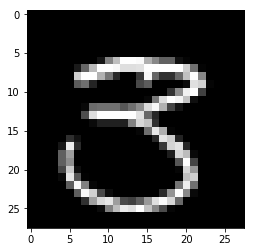

In [82]:
plt.imshow(img_arr, cmap='gray')

One thing to note about the intensity value of images: they should either be int in range 0 to 255, or floats in range 0, 1.

In [16]:
img_arr.dtype

dtype('int64')

In [17]:
pd.DataFrame(img_arr)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,21,...,96,16,4,0,0,0,0,0,0,0
7,0,0,0,0,0,0,26,102,186,254,...,254,254,206,112,4,0,0,0,0,0
8,0,0,0,0,0,0,207,254,254,177,...,48,103,192,254,135,0,0,0,0,0
9,0,0,0,0,0,0,91,111,36,0,...,0,0,12,224,210,5,0,0,0,0


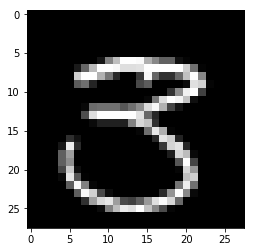

In [18]:
plt.imshow(img_arr, cmap='gray')

In [83]:
img_arr_float = img_arr / 255.

In [84]:
pd.DataFrame(img_arr_float).round(2)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.08,...,0.38,0.06,0.02,0.00,0.00,0.00,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.00,0.00,0.10,0.40,0.73,1.00,...,1.00,1.00,0.81,0.44,0.02,0.00,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.00,0.00,0.81,1.00,1.00,0.69,...,0.19,0.40,0.75,1.00,0.53,0.00,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.00,0.00,0.36,0.44,0.14,0.00,...,0.00,0.00,0.05,0.88,0.82,0.02,0.0,0.0,0.0,0.0


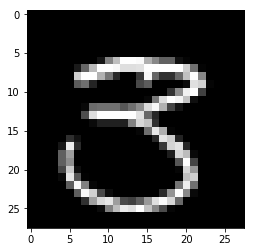

In [85]:
plt.imshow(img_arr_float, cmap='gray')

Since PyTorch expects each image to have at least 1 channel, I'll need to force a "channel" on the image. Usually channels are the final dimension of a multi dimensional array, but PyTorch wants them at the start.

In [86]:
img_arr_float = img_arr_float.reshape(1, 28, 28)

In [87]:
img_arr_float.shape

(1, 28, 28)

I also need to convert any Numpy array into Torch tensors:

In [88]:
img_tensor = torch.from_numpy(img_arr_float)

In [89]:
img_tensor.shape

torch.Size([1, 28, 28])

Lastly, I need to add a batch dimension to it using `unsqueeze(0)`, since all data fed into PyTorch model should be a batch:

In [96]:
img_tensor = img_tensor.unsqueeze(0).cpu().float()

In [97]:
img_tensor.shape

torch.Size([1, 1, 28, 28])

## ConvNet step through

Let's start with the first ConvLayer in Jeremy's spreadsheet example.

It expects an image with a single input channel, then outputs an image 2 with channels. It uses a kernel size of 3 and leaves the stride at the default of 1.

We can use the ``nn.Conv2d`` class to create a convolution.

In [90]:
conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3)

Note that a convolution is simply a matrix which is "convoled" over some input image.

In [101]:
conv1.weight.shape

torch.Size([2, 1, 3, 3])

In [98]:
img_output = conv1(Variable(img_tensor))

In [100]:
img_output[0].shape

torch.Size([2, 26, 26])

Since we didn't specify any padding, we end up with image 2 pixels smaller on both dimensions. We now have an image-like thing with 2 channels.

These are the first 2 ouputs on Jeremy's spreadsheet.

Let's perform the 2nd Conv operation:

In [102]:
conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3)

In [103]:
conv2.weight.shape

torch.Size([2, 2, 3, 3])

In [104]:
img_output2 = conv2(img_output)

In [105]:
img_output2.shape

torch.Size([1, 2, 24, 24])

When we look at the output values, we can see there are a lot of negative values.

In [106]:
img_output2[0]

Variable containing:
(0 ,.,.) = 
 -0.1028 -0.1028 -0.1028  ...  -0.1028 -0.1028 -0.1028
 -0.1028 -0.1028 -0.1028  ...  -0.1028 -0.1028 -0.1028
 -0.1028 -0.1028 -0.1028  ...  -0.1028 -0.1028 -0.1028
           ...             ⋱             ...          
 -0.1036 -0.1247 -0.0379  ...  -0.0645 -0.1028 -0.1028
 -0.1028 -0.1100 -0.0983  ...  -0.0882 -0.1028 -0.1028
 -0.1028 -0.1028 -0.1100  ...  -0.1017 -0.1028 -0.1028

(1 ,.,.) = 
  0.2818  0.2818  0.2818  ...   0.2818  0.2818  0.2818
  0.2818  0.2818  0.2818  ...   0.2818  0.2818  0.2818
  0.2818  0.2818  0.2818  ...   0.2818  0.2818  0.2818
           ...             ⋱             ...          
  0.2813  0.2624  0.2145  ...   0.2691  0.2818  0.2818
  0.2818  0.2773  0.2458  ...   0.2714  0.2818  0.2818
  0.2818  0.2818  0.2772  ...   0.2809  0.2818  0.2818
[torch.FloatTensor of size 2x24x24]

We can remove those with the Relu operation:

In [107]:
img_output_relu = F.relu(img_output2)

In [108]:
img_output_relu[0]

Variable containing:
(0 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

(1 ,.,.) = 
  0.2818  0.2818  0.2818  ...   0.2818  0.2818  0.2818
  0.2818  0.2818  0.2818  ...   0.2818  0.2818  0.2818
  0.2818  0.2818  0.2818  ...   0.2818  0.2818  0.2818
           ...             ⋱             ...          
  0.2813  0.2624  0.2145  ...   0.2691  0.2818  0.2818
  0.2818  0.2773  0.2458  ...   0.2714  0.2818  0.2818
  0.2818  0.2818  0.2772  ...   0.2809  0.2818  0.2818
[torch.FloatTensor of size 2x24x24]

We can also create a maxpool with a 2x2 kernel:

In [109]:
maxpool = nn.MaxPool2d(kernel_size=2)

In [110]:
img_output_maxpool = maxpool(img_output_relu)

In [111]:
img_output_maxpool.shape

torch.Size([1, 2, 12, 12])

Notice how it halves the height and width of the output image?

The last step in the CNN that Jeremy explains in the spreadsheet is to pass to a Linear layer aka a Fully Connected layer aka a dot product.

To pass our image to a linear layer, we'll need to first flatten it out into a vector:

In [112]:
img_flatten = img_output_maxpool.view(1, -1)

In [113]:
img_flatten.shape

torch.Size([1, 288])

We can then create a linear layer with 288 input dimensions and 10 output dimensions (the number of classes in the MNIST problem):

In [114]:
linear = nn.Linear(288, 10)

A linear layer is really just a matrix which can be used to perform a dot product with the input vector:

In [115]:
linear.weight.transpose(1, 0).shape

torch.Size([288, 10])

In [116]:
output = linear(img_flatten)

We now have a set of predictions returned from our model:

In [117]:
output

Variable containing:
 0.0117  0.1441  0.0879 -0.1065  0.0182 -0.0319 -0.2312  0.0805 -0.0286 -0.0169
[torch.FloatTensor of size 1x10]

The last thing to do is to pass it through a SoftMax layer, which converts the outputs into probability-like numbers (sum to 1 and each between 0 and 1), and generally picks 1.

In [118]:
F.softmax(output, dim=1)

Variable containing:
 0.1014  0.1158  0.1094  0.0901  0.1021  0.0971  0.0795  0.1086  0.0974  0.0985
[torch.FloatTensor of size 1x10]

### Putting it all together

In [119]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(SimpleCNN, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=2, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3)

        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=288, out_features=10)
        
    def forward(self, img_batch):
        conv1_output = self.conv1(img_batch)
        conv1_output = F.relu(conv1_output)
        
        conv2_output = self.conv2(conv1_output)
        conv2_output = F.relu(conv2_output)
        
        maxpool_output = self.max_pool(conv2_output)
        
        flattened_output = maxpool_output.view(img_batch.size(0), -1)
        
        output = self.fc1(flattened_output)
        return F.log_softmax(output, dim=1)

In [120]:
cnn = SimpleCNN()

In [121]:
torch.exp(cnn.forward(Variable(img_tensor)))

Variable containing:
 0.0961  0.0900  0.1099  0.0949  0.0965  0.1066  0.1003  0.1000  0.1080  0.0979
[torch.FloatTensor of size 1x10]

## Train with Fast.ai ConvLearner

I'm going to loop through the rows in the DataFrame, convert each to a 28x28 matrix, then stack those 3 times to make a 28x28x3 image. I'll then save it to disk, so I can use the Fast.ai stuff we've learned so far.

In [122]:
from pathlib import Path 

train_path = PATH/'train'
train_path.mkdir(exist_ok=True)

In [123]:
from PIL import Image

img_ids = []
labels = []

for idx, row in tqdm_notebook(df.iterrows(), total=len(df)):
    label = row[0]

    img_vect = np.array(row[1:], dtype=np.uint8)
    img_arr = img_vect.reshape(28, 28)

    # Convert to 3 channels
    img_arr = np.stack((img_arr,) * 3, axis=-1)

    plt.imsave(str(train_path/f'{idx}.jpg'), img_arr)
    
    img_ids.append(idx)
    labels.append(label)

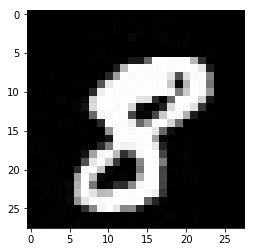

In [124]:
img = plt.imread(train_path/'10.jpg')
plt.imshow(img, cmap='gray')

In [125]:
train_df = pd.DataFrame({'id': img_ids, 'label': labels})
train_df.to_csv(PATH/'train_prepared.csv', index=False)

I can then create a ImageClassifierData object as usual, use the `from_model_data` constructor to create a `ConvLearner` from my custom model.

In [126]:
val_idx = get_cv_idxs(len(train_df))

In [165]:
cnn = SimpleCNN(in_channels=3)

In [166]:
data = ImageClassifierData.from_csv(
    PATH, 'train', PATH/'train_prepared.csv', tfms=tfms_from_model(cnn, 28), val_idxs=val_idx, suffix='.jpg')

In [167]:
conv_learner = ConvLearner.from_model_data(cnn, data)

In [168]:
conv_learner.lr_find()

epoch      trn_loss   val_loss   accuracy                    
    0      2.392927   2.656689   0.108214  


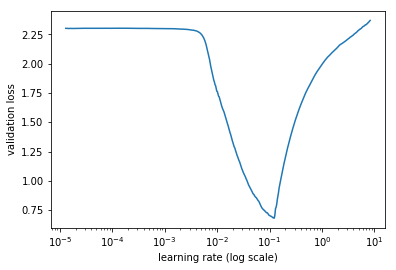

In [169]:
conv_learner.sched.plot()

In [170]:
conv_learner.fit(0.02, 3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.19918    0.163532   0.953214  
    1      0.160023   0.204015   0.937143                    
    2      0.152315   0.148842   0.954643                    


[array([0.14884]), 0.9546428571428571]

In [171]:
conv_learner.fit(0.001, 3)

epoch      trn_loss   val_loss   accuracy                     
    0      0.092366   0.12101    0.96381   
    1      0.090137   0.120243   0.964643                     
    2      0.086826   0.117625   0.965714                     


[array([0.11763]), 0.9657142857142857]

In [172]:
test_df = pd.read_csv(PATH/'test.csv')

In [173]:
img_1 = test_df.loc[5, [c for c in df.columns if c.startswith('pixel')]]
img_arr = np.array(img_1)
img_arr = img_arr.reshape((28, 28))
img_float = np.array(img_arr) * (1/255)
img_float = np.stack((img_float,) * 3, axis=-1)
img_float = img_float.transpose((2, 0, 1))
img_tensor = torch.from_numpy(img_float)
img_tensor = img_tensor.unsqueeze(0).cpu().float()

In [174]:
preds = torch.exp(conv_learner.model(Variable(img_tensor)))

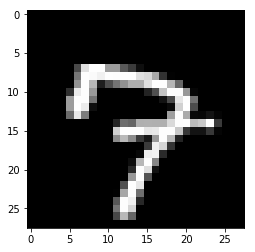

In [175]:
plt.imshow(img_arr, cmap='gray')

In [176]:
preds

Variable containing:
 0.0024  0.0016  0.0083  0.0193  0.0244  0.0135  0.0014  0.6574  0.0360  0.2357
[torch.FloatTensor of size 1x10]

In [177]:
np.argmax(torch.exp(preds.data).numpy())

7